# Tutorial on diffusion models

![img](https://a.storyblok.com/f/191576/512x512/4acff01581/bananelemons.gif)



* [I) Diffusion models: Theory](#chapter1)
    * [1) Probabilistic diffusion models, a gentle introduction](#section_1_1)
    * [2) Diffusion models throught ODE](#sub_section_1_2)
* [II) Exemple code using diffusers librairy](#chapter2)
    * [1) DDPM](#section_2_1)
    * [2) DDIM](#section_2_2)
    * [3) Classifier guidance](#section_2_3)
    * [4) Classifier-free guidance](#section_2_4)
    * [5) Stable diffusion](#section_2_5)
* [III) Diffusion models for inverse problems](#chapter3)
    * [1) DPS](#section_3_1)
    * [2) $\Pi$GDM](#section_3_2)

# I) Diffusion models: Theory<a class="anchor" id="chapter1"></a>

## 0) A brief recall about generative models

The main idea is to train a model to generate images. Basically, the models are trained on a given dataset $\mathcal{D}$ that is supposed to represent samples from a given distribution $\mathcal{D} = \{ x_i | \forall i \in [ 0, n ], x_i \sim p(x) \}$ and we want the model to generate (unseen) data from $p(x)$.
![DDPM](images_notebook/generative_models.png)

## 1) Probabilistic diffusion models, a gentle introduction <a class="anchor" id="section_1_1"></a>

![DDPM](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png)

We want to approximate an unknown distribution $p(x_0)$, the distribution of our images. 

To do so, we build a Markov chain such that:

$$\begin{align}
& q(x_{1:T}|x_0) = \prod_{i=1}^T{p(x_{i}|x_{i-1})} \\
& q(x_{i}|x_{i-1}) = \mathcal{N}(x_i;\sqrt{1-\beta_i}x_{i-1}, \beta_i Id) \\
& X_i = \sqrt{1-\beta_i}X_{i-1}  + \sqrt{\beta_i} \epsilon \quad with \quad \epsilon \sim \mathcal{N}(0,Id) \\
& X_i = \sqrt{\bar{\alpha_i}}X_{0}  + \sqrt{1-\bar{\alpha_i}} \epsilon \quad with \quad \epsilon \sim \mathcal{N}(0,Id), \ \ \bar{\alpha_i} = \prod_{j=1}^i{(1-\beta_i)}
\end{align}$$

The main idea behind diffusion models is to estimate the reverse process $q(x_{i-1}|x_{i})$.
**"For both Gaussian and binomial diffusion, for continuous diffusion (limit of small step size β) the reversal of the diffusion process has the identical functional form as the forward process (Feller, 1949)." (see [here](https://arxiv.org/pdf/1503.03585.pdf))**. We then can use a Gaussian with learned mean and variance to approximate $q(x_{i-1}|x_{i})$.

$$ p_\theta(x_{i-1}|x_{i}) = \mathcal{N}(x_t; \mu_\theta(x_t,t), \sigma_\theta(x_t,t))$$

After some theory and supposing that we have a noise predictor (or a score matching network) $\textbf{s}(x_t, t)$, we end with:
- $\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}} \left(x_{t} - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha_t}}} \textbf{s}(x_t, t)\right)$
- $\sigma_\theta(x_t,t) = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_{t}}\beta_t$

The design of the denoiser is a Residual U-Net with self attention blocks that is inspired from [PixelCNN++](https://arxiv.org/abs/1701.05517). An important property for diffusion models is that they need to have a large receptive field (to the size of the image) in order to have coherent generation. Another "trick" that is used is **Transformer sinusoidal position embedding** that is used to inject the timesteps into the architecture. The embedded timesteps are injected into each residual blocks. 

References:
- Pioneer work (among the recent ones): https://arxiv.org/pdf/1503.03585.pdf
- DDPM: https://arxiv.org/pdf/2006.11239.pdf
- PixelCNN++: https://arxiv.org/abs/1701.05517
- A nice blog that does all the maths behind diffusion models: https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

## 2) Diffusion models throught ODE<a class="anchor" id="section_1_2"></a>

![song_ode](https://raw.githubusercontent.com/yang-song/score_sde/main/assets/schematic.jpg)

Target distribution $x_T \sim \mathcal{N}(0,1)$, data distribution $p(x_0)$. This diffusion process can be modeled as the solution of an Ito SDE:
$$dx = − \frac{\beta(t)}{2} x dt + \sqrt{\beta(t)} dw $$
with $w$ a Wiener process.
There is a results that state "the reverse of a diffusion process is also a diffusion process, running backwards in time and given by the reverse-time SDE":
$$ dx = \left(− \frac{\beta(t)}{2} x - \beta(t) \nabla_{x_t} \log{p_t(x_t)}\right) dt + \sqrt{\beta(t)}d\bar{w}$$
where $dt$ corresponds to time running backard and $\bar{w}$ the standar Wiener process running backward. If you want to understand why, check [here](https://core.ac.uk/download/pdf/82826666.pdf).

References:
- ODE theory: https://core.ac.uk/download/pdf/82826666.pdf
- VE-SDE: https://arxiv.org/pdf/2011.13456.pdf

# II) Exemple code using diffusers librairy<a class="anchor" id="chapter2"></a>

In [1]:
import matplotlib.pyplot as plt
import torch
import tqdm

import utils.utils_image as util

/home/claroche/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##  1) DDPM: Denoising Diffusion Probabilistic Models<a class="anchor" id="section_2_1"></a>

***
$\mathbf{\text{DDPM Algorithm}}$<br>
***
1.&emsp;Initialize $x_T \sim \mathcal{N}(0,1)$<br>
2.&emsp;For t = T to 0:<br>
&emsp; &emsp; $\widehat{s} = \textbf{s}(x_t, t)$<br>
&emsp; &emsp; $\epsilon = \mathcal{N}(0,1)$ <br>
&emsp; &emsp; $x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_{t} - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha_t}}}  \widehat{s}\right) + \sqrt{\beta_t}\epsilon$
<br>

3. Output $x_0$
***

### Using pipeline

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.51it/s]


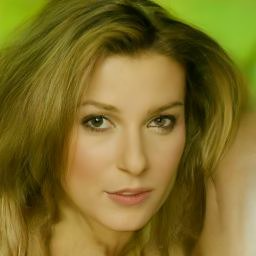

In [2]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256").to("cuda")
image = ddpm(num_inference_steps=100).images[0]
image

### What's behind

In [3]:
from diffusers import DDPMScheduler, UNet2DModel

#scheduler = DDIMScheduler.from_pretrained("google/ddpm-church-256")
#model = UNet2DModel.from_pretrained("google/ddpm-church-256").to("cuda")

#scheduler = DDIMScheduler.from_pretrained("ddpm-div2k-256/scheduler")
#model = UNet2DModel.from_pretrained("ddpm-div2k-256/unet").to("cuda")

scheduler = DDPMScheduler.from_pretrained("google/ddpm-celebahq-256")
model = UNet2DModel.from_pretrained("google/ddpm-celebahq-256").to("cuda")

scheduler.set_timesteps(100)

In [4]:
def ddpm_sampling(model, scheduler, n_samples=1):
    # Get hyper_params
    sample_size = model.config.sample_size
    
    # Init random noise
    input = torch.randn((n_samples, 3, sample_size, sample_size)).to("cuda")
    
    for t in tqdm.tqdm(scheduler.timesteps):
        with torch.no_grad():
            # Get noisy residual
            noisy_residual = model(input, t).sample
            
            # Get update 
            input = scheduler.step(noisy_residual, t, input).prev_sample

    # Normalize output
    image = (input / 2 + 0.5).clamp(0, 1)
    return image

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.05it/s]


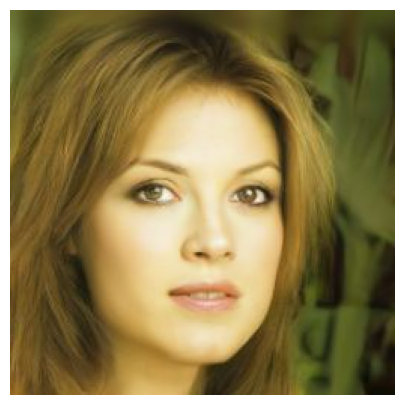

In [5]:
res = ddpm_sampling(model, scheduler)
plt.figure(figsize=(5, 5))
plt.imshow(util.tensor2uint(res))
plt.axis('off')
plt.show()

## 2) DDIM: Denoising Diffusion Implicit Models<a class="anchor" id="section_2_2"></a>

DDIM goal is to accelerate DDPM. They design a diffusion model for non-Markovian forward process. This trick allows DDIM to work with deterministic forward process and thus predict the sample without noise addition which is why diffusion models are so long. DDIM shows how to choose the variance and timesteps scheme if the denoiser was trained for $N_d$ and the inference is run on $N_i$ steps. Let $\tau$ be different subsequences of $[0, T]$, the variance at step i is given by:

$$\sigma_{\tau_i}(\eta)= \eta \sqrt{\frac{1−\alpha_{\tau_{i-1}}}{1−\alpha_{\tau_{i}}}}\sqrt{1 - \frac{\alpha_{\tau_{i}}}{\alpha_{\tau_{i-1}}}}$$

Another idea that can be drawn from DDIM is deterministic sampling by setting $\eta$ to 0. $\eta=1$ corresponds to DDPM.
***
$\mathbf{\text{DDIM Algorithm}}$<br>
***
1.&emsp;Initialize $x_T \sim \mathcal{N}(0,1)$<br>
2.&emsp;For $i = N_i$ to 0:<br>
&emsp; &emsp; $\widehat{s} = \mathcal{D}(x_{\tau_i}, \tau_i)$<br>
&emsp; &emsp; $\epsilon = \mathcal{N}(0,1)$ <br>
&emsp; &emsp; $\sigma_{\tau_i}(\eta)= \eta \sqrt{\frac{1−\alpha_{\tau_{i-1}}}{1−\alpha_{\tau_{i}}}}\sqrt{1 - \frac{\alpha_{\tau_{i}}}{\alpha_{\tau_{i-1}}}}$<br>
&emsp; &emsp; $x_{\tau_{i-1}} = \sqrt{\alpha_{\tau_{i-1}}} \left(\frac{x_{\tau_i} - \sqrt{1 - \alpha_{\tau_i}}\widehat{s}}{\sqrt{\alpha_{\tau_i}}}\right) + \sqrt{1 - \alpha_{\tau_{i-1}} - \sigma_{\tau_i}^2} \widehat{s} + \sigma_{\tau_i}^2\epsilon$
<br>

3. Output $x_0$
***

In [6]:
from diffusers import DDIMScheduler

scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
model = UNet2DModel.from_pretrained("google/ddpm-celebahq-256").to("cuda")

scheduler.set_timesteps(100)

In [7]:
def ddim_sampling(model, scheduler, n_samples=1, eta=1, generator=None):
    # Get hyper_params
    sample_size = model.config.sample_size
    
    # Init random noise
    input = torch.randn((n_samples, 3, sample_size, sample_size), generator=generator).to("cuda")
    
    for t in tqdm.tqdm(scheduler.timesteps):
        with torch.no_grad():
            # Get noisy residual
            noisy_residual = model(input, t).sample
            
            # Get update 
            input = scheduler.step(noisy_residual, t, input, eta=eta, generator=generator).prev_sample

    # Normalize output
    image = (input / 2 + 0.5).clamp(0, 1)
    return image

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.01it/s]


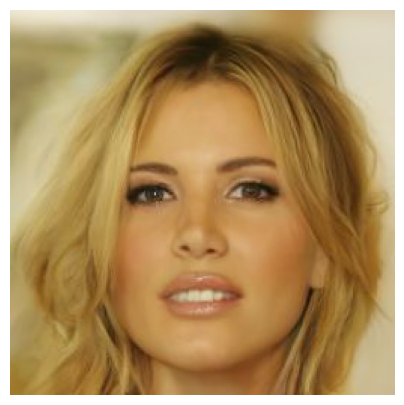

In [8]:
res = ddim_sampling(model, scheduler)
plt.figure(figsize=(5, 5))
plt.imshow(util.tensor2uint(res))
plt.axis('off')
plt.show()

## 3) Conditional diffusion models with classifier guidance<a class="anchor" id="section_2_3"></a>

In DDPM, we want to estimate $p(x)$ the distribution of the data. If we want to condition on something, let say a label or a text prompt, we want to estimate $p(x|y)$ with $y$ the label/prompt.

Bayes' rule:

$$ p(x|y) = \frac{p(y|x)p(x)}{p(y)}$$

So we have: 

$$ \nabla_{x_t} \log{p(x_t|y)} = \nabla_{x_t} \log{p(y|x_t)} + \nabla_{x_t} \log{p(x_t)} $$

An intersting property is that a Classifier exactly target $\log{p(y|x_t)}$. The main idea of classifier guidance is to use a classifier to replace $ \nabla_{x_t} \log{p(y|x_t)}$ thanks to autograd.

References:
- Original paper: https://arxiv.org/pdf/2105.05233.pdf

## 4) Classifier-free diffusion Guidance<a class="anchor" id="section_2_4"></a>

The idea is to train both a unconditional $\mathcal{D}(x_t, t, \emptyset)$ and a conditional score estimator $\mathcal{D}(x_t, t, y)$. When sampling, the score estimates is $\tilde{\epsilon}_\theta(x_t, t, c) = (1+w)\mathcal{D}(x_t, t, c)  - w \mathcal{D}(x_t, t, \emptyset)$.

References:
- Classifier-free guidance: https://arxiv.org/pdf/2207.12598.pdf

## 5) Stable diffusion<a class="anchor" id="section_2_5"></a>

![stable_diffusion](https://jalammar.github.io/images/stable-diffusion/article-Figure3-1-1536x762.png)
The main idea of stable diffusion is to do the diffusion process in the latent space. To do so, they use an autoencoder (VQGAN). In addition, they also offer the possibility to do conditionning similarly to "**Classifier-free guidance**". The main idea is to sample from $p(x|\tau_\theta(y))$ where $\tau_\theta(.)$ is a domain specific label encoder that can be a text-embedding network, an image encoder and so on. They generally use **CLIP** for the label encoder.

They however integrate cross-attention layers everywhere in order to better condition on complex and diverse inputs. 

References:
- VQGAN: https://arxiv.org/abs/2012.09841
- CLIP: https://arxiv.org/pdf/2103.00020.pdf
- StableDiffusion: https://arxiv.org/pdf/2112.10752.pdf

In [9]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler

torch_device = "cuda"

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(torch_device)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder").to(torch_device)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(torch_device)

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [10]:
def stable_diffusion(prompt, height=512, width=512, n_step=25, guidance_scale=7.5, generator=None):
    batch_size = len(prompt)
    scheduler.set_timesteps(n_step)
    
    # Tokenization of the prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length,
                           truncation=True, return_tensors="pt")
    
    # Text embedding
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    
    
    # Unconditionnal text embedding (no condition token)
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    
    # Get our final embedding
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    # Initialization of the latent
    latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),
                          generator=generator).to(torch_device)
    
    
    # Scaling of the latent
    latents = latents * scheduler.init_noise_sigma
    
    # Diffusion loop
    for t in tqdm.tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

        # predict the noise residual, conditionned on the text embeddings
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance unsing classifier free guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
        
    image = (image / 2 + 0.5).clamp(0, 1)
    
    return image

/tmp/ipykernel_1761906/3164677420.py:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.71it/s]


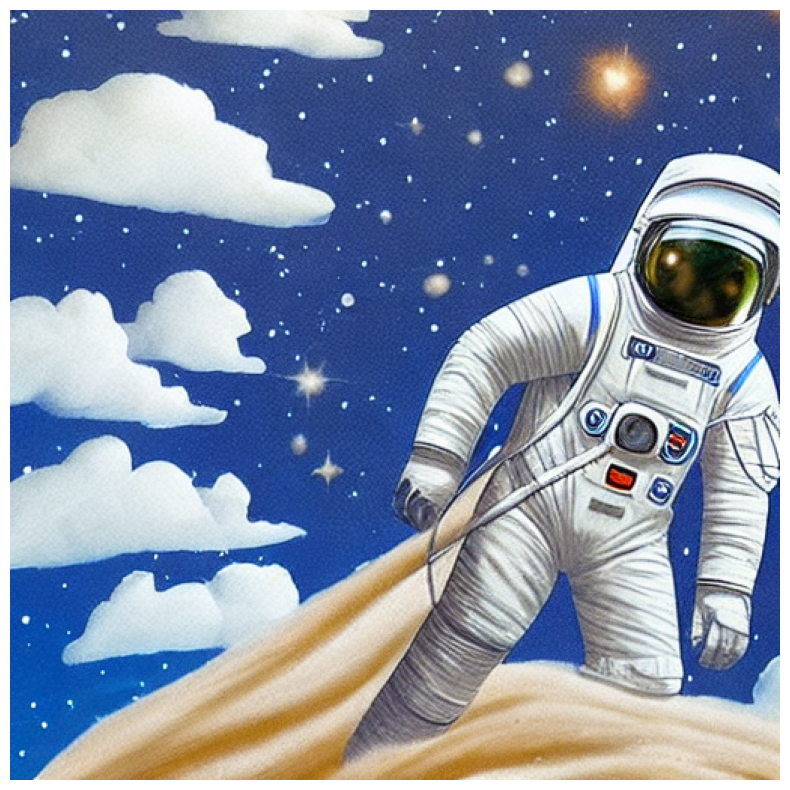

In [11]:
for i in range(1): 
    prompt = ['an astronaut on a horse']
    res = stable_diffusion(prompt)
    plt.figure(figsize=(10,10))
    plt.imshow(util.tensor2uint(res))
    plt.axis('off')
    plt.show()

# III) Diffusion models for inverse problems<a class="anchor" id="chapter3"></a>

Image restoration tasks can be modelled as inverse problems. In this section, we discuss how we can inject the information contained in the inverse problem formulation into the diffusion model. Let us start with the classical inverse problem formulation:

$$
\begin{align}
    y = Hx + \epsilon \quad \text{with} \quad \epsilon \sim \mathcal{N}(0, \sigma^2)
\end{align}
$$
In terms of probability distribution, it can be seen as:
$$
\begin{align}
    p(y|x) = \mathcal{N}(Hx,\sigma^2)
\end{align}
$$

****

Let us re-write the reverse SDE of the diffusion process to sample from a distribution $p(x_0)$:

$$ dx = \left(− \frac{\beta(t)}{2} x - \beta(t) \nabla_{x_t} \log{p_t(x_t)}\right) dt + \sqrt{\beta(t)}d\bar{w}$$

In our, case, we want to sample from $p(x_0|y)$. Using the Bayes' rule, we obtain that:

$$\nabla_{x_t} \log{p(x_t|y)} = \nabla_{x_t} \log{p_t(x_t)} + \nabla_{x_t} \log{p_t(y|x_t)}$$

That could be it but on challenge here is that we do not know the distribution $p_t(y|x_t)$ but $p_t(y|x_0)$. 

<div>
<img src="images_notebook/DPS_distrib.png" width="300"/>
</div>

Using the law of total probability we have:

$$p(y|x_t) = \int p(x_0|x_t)p(y|x_0)dx_0$$

The computation of this integral relies on the approximation of $p(x_0|x_t)$. In the next section, we present two paper with two different approximation of this quantity.

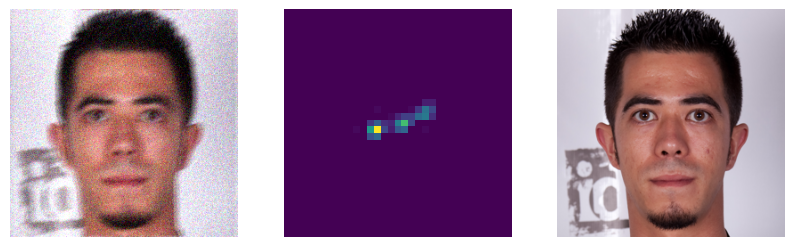

In [12]:
from data.data_blur import Dataset

data_opt = {'dataroot_H': '/home/claroche/Documents/GitHub-claroche-r/DiffusionEM/results/FFHQ/GT/H',
            'dataroot_kernels': '/home/claroche/Documents/GitHub-claroche-r/DiffusionEM/kernels/custom_blur.mat',
            'sigma': [1,2]}

data = Dataset(data_opt)

sample = data[4]

plt.figure(figsize=(10, 10/3))
plt.subplot(131)
plt.imshow(util.tensor2uint(sample['L']))
plt.axis('off')
plt.subplot(132)
plt.imshow(util.tensor2uint(sample['kernel']))
plt.axis('off')
plt.subplot(133)
plt.imshow(util.tensor2uint(sample['H']))
plt.axis('off')
plt.show()

## 1) Diffusion by Posterior Sampling (DPS)<a class="anchor" id="section_3_1"></a>

In DPS, they approximate $p(x_0|x_t)$ by a dirac in the mean $\widehat{x_0} = E[x_0|x_t]$. In other words, $p(x_0|x_t) = \mathbb{1}(x_0 = \widehat{x_0})$.

It leads to:

$$\nabla_{x_t}\log{p(y|x_t)} = \nabla_{x_t} {\frac{1}{2\sigma^2}\|H\widehat{x_0}(x_t) - y\|_2^2}$$

We can compute $\widehat{x_0}$ with the formula:

$$ \widehat{x_0} = \frac{1}{\sqrt{\bar{\alpha}_t}}(x_t + (1-\bar{\alpha}_t)\textbf{s}(x_t, t))$$

and torch.autograd do all the job.

***
This method have one main advantage, it does not require the forward model $Hx$ to be linear or invertible. We can use any forward model $\mathcal{A}(x)$ as long as we can auto differentiate it. However, I observed that the "guidance" is not strong enough so it requires many iterations of DDPM to converge (1000).

In [13]:
import utils.utils_agem as agem

def dps_samplign(model, scheduler, y, forward_model, n, scale=1):
    sample_size = model.config.sample_size
    
    # Init random noise
    input = torch.randn((n, 3, sample_size, sample_size)).to("cuda")

    for t in tqdm.tqdm(scheduler.timesteps):
        # Predict noise
        input.requires_grad_()
        noisy_residual = model(input, t).sample

        # Get x_prec and x0_hat
        pred = scheduler.step(noisy_residual, t, input, eta=1)
        x0_hat = agem.clean_output(pred.pred_original_sample)
        x_prec = pred.prev_sample

        # Guidance
        f = torch.norm(forward_model(x0_hat) - y)
        norm_grad = torch.autograd.grad(outputs=f, inputs=input)[0]
        input = x_prec - scale * norm_grad
        input = input.detach_()

    return agem.clean_output(input)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:11<00:00,  7.61it/s]


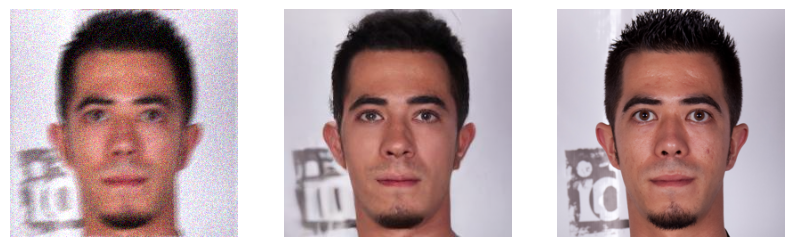

In [14]:
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
model = UNet2DModel.from_pretrained("google/ddpm-celebahq-256").to("cuda")
scheduler.set_timesteps(1000)

forward_model = lambda x: agem.fft_blur(x, sample['kernel'].to('cuda'))
res = dps_samplign(model, scheduler, sample['L'].to('cuda'), forward_model, 1)

plt.figure(figsize=(10, 10/3))
plt.subplot(131)
plt.imshow(util.tensor2uint(sample['L']))
plt.axis('off')
plt.subplot(132)
plt.imshow(util.tensor2uint(res))
plt.axis('off')
plt.subplot(133)
plt.imshow(util.tensor2uint(sample['H']))
plt.axis('off')
plt.show()

## 2)  Pseudoinverse-Guided Diffusion Models ($\Pi$GDM))<a class="anchor" id="section_3_2"></a>

In $\Pi$GDM, $p(x_0|x_t)$ is approximated with a Gaussian distribution. We have $p(x_0|x_t)\sim \mathcal{N}(\widehat{x_0}, r_t^2)$.

With some computation, we can obtain that:

$$p(y|x_t) \sim \mathcal{N}(H\widehat{x_0}, r_t^2 HH^T + \sigma^2Id)$$

with leads to:
$$\nabla_{x_t} \log{p(y|x_t)} = \left(\frac{\partial \widehat{x_0}(x_t)}{\partial x_t}\right)^T H^T (r_t^2 HH^T + \sigma^2Id)^{-1} (y - H \widehat{x_0})$$

Autograd is able to do most of the job, but we still need to invert $(r_t^2 HH^T + \sigma^2Id)$. This cannot be done for many forward operator $H$.
***
$\Pi$GDM "guidance" is more efficient that DPS, which means we do not need as much iterations as DPS (between 50 and 100). However, the cost of a strong guidance comes with limitations on the complexity of the forward operator $H$.

In [15]:
import torch.fft as fft

def pinv_deblurring(x, k, r=1, sigma=1e-8):
    k = agem.p2o(k, x.shape[-2:])
    Fk = fft.fft2(k)
    FkC = Fk.conj()
    Fk2 = Fk.mul(FkC)
    num = FkC
    den = r ** 2 * Fk2 + sigma ** 2
    res = (num / den) * fft.fft2(x)
    return fft.ifft2(res).real

def deblurring_guidance(y, x, k, sigma=0, r=1):
    if sigma == 0:
        sigma += 1e-8
    return pinv_deblurring(y, k, r=r, sigma=sigma) - pinv_deblurring(agem.fft_blur(x, k), k, r=r, sigma=sigma)

In [16]:
def pigdm_sampling(model, scheduler, y, sigma, guidance, n, scale=1):    
    sample_size = model.config.sample_size
    step_size = scheduler.config.num_train_timesteps // scheduler.num_inference_steps
    
    # Init random noise
    input = torch.randn((n, 3, sample_size, sample_size)).to("cuda")

    for t in tqdm.tqdm(scheduler.timesteps):
        # Computation of some hyper-params
        prev_t = t - step_size
        variance = scheduler._get_variance(t, prev_t)
        r = torch.sqrt(variance/(variance + 1))
        current_alpha_t = 1 / (1 + variance)

        # Predict noise
        input.requires_grad_()
        noisy_residual = model(input, t).sample

        # Get x_prec and x0_hat
        pred = scheduler.step(noisy_residual, t, input, eta=1)
        x0_hat = agem.clean_output(pred.pred_original_sample)
        x_prec = pred.prev_sample

        # Guidance
        g = (guidance(y, x0_hat, sigma=sigma, r=r).detach() * x0_hat).sum()
        grad = torch.autograd.grad(outputs=g, inputs=input)[0]
        input = input.detach_()

        # Update of x_t
        input = x_prec + scale * grad * (r ** 2) * torch.sqrt(current_alpha_t)

    return agem.clean_output(input)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.62it/s]


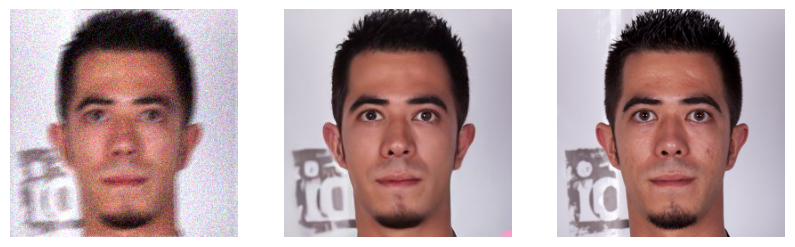

In [17]:
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
model = UNet2DModel.from_pretrained("google/ddpm-celebahq-256").to("cuda")
scheduler.set_timesteps(100)

guidance = lambda y, x, sigma, r: deblurring_guidance(y, x, sample['kernel'].to('cuda'), sigma=sigma, r=r)
res = pigdm_sampling(model, scheduler, sample['L'].to('cuda'), sample['sigma'], guidance, 1)

plt.figure(figsize=(10, 10/3))
plt.subplot(131)
plt.imshow(util.tensor2uint(sample['L']))
plt.axis('off')
plt.subplot(132)
plt.imshow(util.tensor2uint(res))
plt.axis('off')
plt.subplot(133)
plt.imshow(util.tensor2uint(sample['H']))
plt.axis('off')
plt.show()